In [1]:
import os
import time
import copy
from collections import defaultdict
import torch
import shutil
import pandas as pd
from skimage import io, transform, segmentation, draw
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import utils
import torchvision.transforms as T
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import helper_functions as myutils

In [2]:
device=myutils.set_to_gpu()
myutils.setup_seed(0)
myutils.gpu_mem_allocated()
TRAIN_PATH="/scratch_tmp/jl11431/Project/stage1_train"
TEST_PATH="/scratch_tmp/jl11431/Project/stage1_test"
IMG_CHANNELS=3

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB
Device being used: cuda


## Define dataset

In [3]:
PATH = '/scratch_tmp/jl11431/Project/stage1_train'
# For training: resize image to atleast 512 at min. side and crop to 512x512
MIN_DIM=512 # resize original image to atleast 512 at the minimum side
CROP_DIM=512 # if larger, crop to 512x512

In [4]:
# Define Custom Classes for transforms

class ToTensor(object):  ## NOTE: ToTensor will divide by 255!
    def __call__(self, image, target):
        image = T.functional.to_tensor(image)
        return image, target
    
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
    
def get_transform(train):
    transforms = []
    transforms.append(ToTensor())
    if(train):
        pass # no further transforms right now...
    return Compose(transforms)

# From https://www.kaggle.com/code/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [5]:
# BELOW IS TAKEN FROM 3rd place entry in competition: "DeepRetina" (https://github.com/Gelu74/DSB_2018)
# "The dataset doesn't have a standard train/val split, so I picked a variety of images to surve as a validation set."
VAL_IMAGE_IDS = [
    "0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2",
    "92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7",
    "1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f",
    "c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339",
    "8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b",
    "60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff",
    "da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844",
    "9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32",
    "1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df",
    "97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034",
    "e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0",
    "f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81",
    "0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1",
    "3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90",
    "ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716",
    "bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676",
    "e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b",
    "947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050",
    "cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd",
    "f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3",
    "4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06",
    "f73e37957c74f554be132986f38b6f1d75339f636dfe2b681a0cf3f88d2733af",
    "a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4",
    "cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2",
]

In [6]:
class NucleusDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, min_dim=MIN_DIM, crop_dim=CROP_DIM, filter_ids=[], transforms=None, use_rle = False, rle_file=None):
        self.root=root # e.g. "stage1_train"
        self.train=train # will resize and random crop the image if True
        self.resize_t=T.Resize((min_dim,min_dim))
        self.crop_dim=crop_dim
        self.transforms = transforms
        self.use_rle = use_rle
        self.rle_file = rle_file 

        # a subset of the train set is being used as validation: "filter_ids": the image ids for validation 
        if(len(filter_ids)>0):
            if(train):
                img_ids=next(os.walk(root))[1]
                self.img_ids=list(set(img_ids) - set(filter_ids))
            else:
                self.img_ids=filter_ids
        else:
            self.img_ids=next(os.walk(root))[1]
        
    def __getitem__(self, idx):

        if(type(idx) == type("")):  # Note: don't use this when sending to model on cuda device
            image_id = idx
            idx=self.img_ids.index(image_id)
        else:
            image_id = self.img_ids[idx] # Use numerical index when sending to model on cuda device
          
        # Load image
        img_file = os.path.join(self.root, image_id, "images", image_id+".png")
        image = Image.open(img_file).convert("RGB") # must return PIL image 
        
        # Load masks 
        if (self.use_rle):
            rle_file = pd.read_csv(self.rle_file)
            # Use decoder to get mask from rle file
            rle_masks = rle_file.loc[rle_file['ImageId'] == image_id, 'EncodedPixels'].tolist()
            masks = np.empty((len(rle_masks),image.height,image.width), dtype=bool)
            for i, mask in enumerate(rle_masks):
                masks[i] = rle_decode(mask,(image.width,image.height))
            masks = torch.as_tensor(masks, dtype=torch.float32)
            
        else:
            # Masks are a series of binary images - one per nucleus
            mask_files = next(os.walk(os.path.join(self.root, image_id, "masks")))[2]
            masks = np.empty((len(mask_files),image.height,image.width), dtype=bool)

            for i,mask_file in enumerate(mask_files):
                masks[i] = io.imread(os.path.join(self.root, image_id, "masks", mask_file)) != 0
 
            masks = torch.as_tensor(masks, dtype=torch.float32)
        # resize image
            
        image=self.resize_t(image)
        print(masks.shape)
        # resize masks
        masks=self.resize_t(masks)
        
        # Resize and random crop for training - apply to both image and masks


        merged_mask = np.zeros((512, 512, 1), dtype=bool)
        for i in range(len(masks)):
                mask_ = masks[i]
                mask_ = np.expand_dims(mask_,axis=-1)
                merged_mask = np.maximum(merged_mask, mask_)
            
        image = T.functional.to_tensor(image)

        if self.transforms is not None: 
            # these transforms must change both image and target as appropriate
            image, merged_mask = self.transforms(image, merged_mask)
        merged_mask = merged_mask.squeeze()
        return image.to(dtype=torch.float32), merged_mask

    def __len__(self):
        return len(self.img_ids)       

In [7]:
num_epochs=10
bs = 6
dataset_dict = {
    'train': NucleusDataset(TRAIN_PATH, train=True, filter_ids=VAL_IMAGE_IDS), 
    'validate': NucleusDataset(TRAIN_PATH, train=False, filter_ids=VAL_IMAGE_IDS ) 
    }
data_loader_dict = {
    'train':torch.utils.data.DataLoader(dataset_dict['train'],
                                        batch_size=bs, 
                                        shuffle=True
                                        ),
                    
    'validate':torch.utils.data.DataLoader(dataset_dict['validate'],
                                        batch_size=bs, 
                                        shuffle=False)
    }

## Prediction with vanilla U-net
### Define vanilla U-net model
We start with a vanilla U-net model to do semantic segmentation

In [8]:
# DoubleConv unit
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

    
class UNet(nn.Module):
    def __init__(
        self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Define down layer
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2)
            )
            self.ups.append(
                DoubleConv(feature*2, feature)
            )
            
        self.bottleneck= DoubleConv(512, 1024)
        self.final = nn.Conv2d(features[0], out_channels, kernel_size = 3, stride = 1, padding = 1)
        
    def forward(self, x):
        skip_connections = []
        # Down
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottle
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # Reverse the list [start:stop;step]
        
        # Up
        for i in range(0, len(self.ups),2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]
            
            x = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[i+1](x)
        
        x = self.final(x)
        return x

### Define metrics


In [9]:
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.cpu().detach().numpy()
    y = y.cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou 

### Train Model
Vanilla U-net cannot predction segmentation automatically, so all mask need to be merged into one file for train

In [10]:
# Function to merge all masks into one file
def merge_mask(masks):
    mask = np.zeros((label['masks'][0].shape[0],label['masks'][0].shape[1],1), dtype=np.uint8)
    for mask_ in label['masks']:
        mask_ = np.expand_dims(mask_,axis=-1)
        mask = np.maximum(mask, mask_)
    return masks

In [11]:
def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pt.tar'): 
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    best_model_epoch=0
    best_score=0
    best_model_wts=None

    score_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        
        loss_dict=checkpoint['loss_dict']
        score_dict=checkpoint['score_dict']

        best_score = checkpoint['best_score']
        best_model_epoch = checkpoint['best_model_epoch']
        best_model_wts = checkpoint['best_model_wts']

        model = model.to(device)

        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return (model, optimizer, scheduler, start_epoch, 
            score_dict, loss_dict, best_model_epoch, best_model_wts, best_score)


In [12]:
def train_model(model, dataloader, optimizer,loss_fn, scheduler, num_epochs = 10, use_checkpoint=True, file_pre="model_state"):

    score_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}

    best_score = 0
    best_model_epoch=0
    best_model_wts=None
    phases = ['train','validate']
    since = time.time()
    
    for i in range(num_epochs):
        
        if(use_checkpoint):
            (model, optimizer, scheduler, i,
            score_dict, loss_dict, best_model_epoch,
            best_model_wts, best_score) = load_checkpoint(model, 
                                                         optimizer, 
                                                         scheduler,
                                                         filename=f"{file_pre}_checkpoint.pt.tar")
                            
        if(i >= num_epochs):
            break  # in case we've already run all epochs
            
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        
        for p in phases:
            
            running_total = 0
            running_loss = 0
            running_score = 0
            
            if p == 'train':
                model.train()
            else:
                model.eval()
            
            # loop through batches:
            #for n, (images,targets) in tqdm(enumerate(dataloader[p]), total=len(dataloader[p])):
            for n, (images,masks) in enumerate(dataloader[p]):
            
                num_imgs=len(images)
                images, masks = images.to(device), masks.to(device)


                if p == 'train':
                    outputs = model(images)
                    outputs = outputs.squeeze()
                    if (outputs.ndim != 3):
                        outputs = outputs.unsqueeze()
                    loss = loss_fn(outputs, masks)
                    model.zero_grad()
                    loss.backward()
                    optimizer.step()
                    score = iou_batch(outputs,masks)
                    running_loss += loss.item()*num_imgs
                    running_score += score*num_imgs
                else:
                    with torch.no_grad():
                        outputs = model(images)
                        outputs = outputs.squeeze()
                        if (outputs.ndim != 3):
                            outputs = outputs.unsqueeze()
                        loss = loss_fn(outputs,masks)
                        score = iou_batch(outputs,masks)
                        running_score+=score*num_imgs
                        running_loss+=loss.item()*num_imgs
                        
                running_total += num_imgs

            
                    
            # Finish up for the epoch:
            if p == 'train':
                epoch_loss=float(running_loss/running_total)
                score_dict['train'].append(float(running_score / running_total))
                loss_dict['train'].append(epoch_loss)  
                elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - since))))
                print('Train set |  Average Loss: {:.4f} | Average Score: {:6.4f} | time elapse: {:>9}'.format(
                    loss_dict['train'][-1], score_dict['train'][-1], elapse))

                if scheduler is not None:
                    scheduler.step()

            else: #p == 'validate':
                epoch_loss=float(running_loss/running_total)
                epoch_score = float(running_score / running_total)
                score_dict['validate'].append(epoch_score)
                loss_dict['validate'].append(epoch_loss)  
                elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - since))))
                print('Validation set |  Average Loss: {:.4f} | Average Score: {:6.4f} | time elapse: {:>9}'.format(
                    loss_dict['validate'][-1], score_dict['validate'][-1], elapse))

                if epoch_score > best_score: 
                    best_score = epoch_score
                    best_model_wts = model.state_dict()
                    best_model_epoch=i
                    
            # SAVE STATE AT END OF EPOCH
        if(use_checkpoint):
                    state = {'epoch': i+1,
                         'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'score_dict': score_dict,
                         'loss_dict': loss_dict,
                         'best_score': best_score,
                         'best_model_epoch': best_model_epoch,
                         'best_model_wts': best_model_wts,
                         } 
                    torch.save(state, f"{file_pre}_checkpoint.pt.tar")
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val score: {:6f}'.format(best_score))
    
    model.load_state_dict(best_model_wts)
    return model,score_dict, loss_dict

In [13]:
def eval_model(model, dataloader):                            
    running_total = 0
    running_score = 0
    model.eval()
    for images,masks in (dataloader):
        num_imgs=len(images)
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            outputs = outputs.squeeze()
            if (outputs.ndim != 3):
                outputs = outputs.unsqueeze()
            score = iou_batch(outputs,masks)
            running_score+=score*num_imgs

        running_total += num_imgs

    mean_score= float(running_score/running_total)
                
    print('Test IoU: {:.6f}'.format(mean_score))

In [13]:
model = UNet()
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(params, lr=1e-4) 
lambda_func = lambda epoch: 0.5 ** epoch 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [18]:
model, score, loss = train_model(model, 
                        dataloader = data_loader_dict, 
                        optimizer = optimizer, 
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        file_pre="Unet-working"
                          )

=> loading checkpoint 'Unet-working_checkpoint.pt.tar'
=> loaded checkpoint 'Unet-working_checkpoint.pt.tar' (epoch 10)
Training complete in 0m 3s
Best val score: 0.486751


Plot loss and IoU score curve

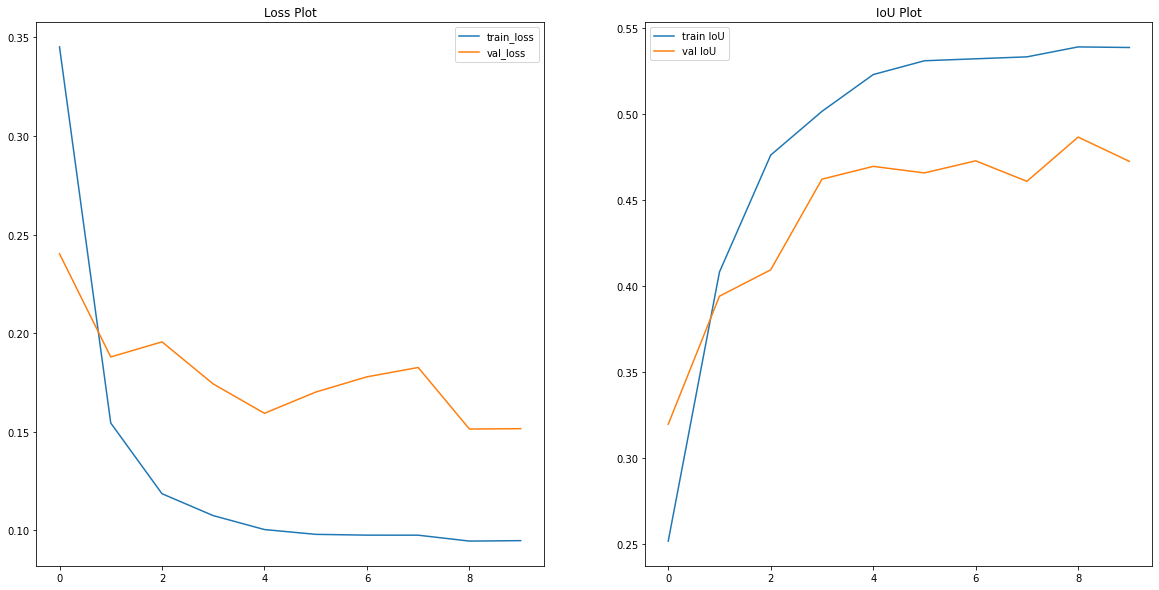

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(loss['train'],label='train_loss')
plt.plot(loss['validate'],label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(score['train'],label='train IoU')
plt.plot(score['validate'],label='val IoU')
plt.legend()
plt.title('IoU Plot')
plt.show()

### Check the performance on test set

In [58]:
bs =6
test_dataset=NucleusDataset(TEST_PATH, train=False, use_rle = True, rle_file = 'stage1_solution.csv')
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=bs, 
                                        shuffle=False)

In [59]:
eval_model(model, test_loader)

Test meanAP: 0.466899


Visualisation of actual and predicted mask

In [19]:
sample, targets = next(iter(test_loader))

In [34]:
sample = sample.to(device)
y_pred = model(sample)
y_pred = torch.sigmoid(y_pred)
y_pred = (y_pred > 0.5).float()
y_pred = y_pred.cpu().detach().numpy()

In [99]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

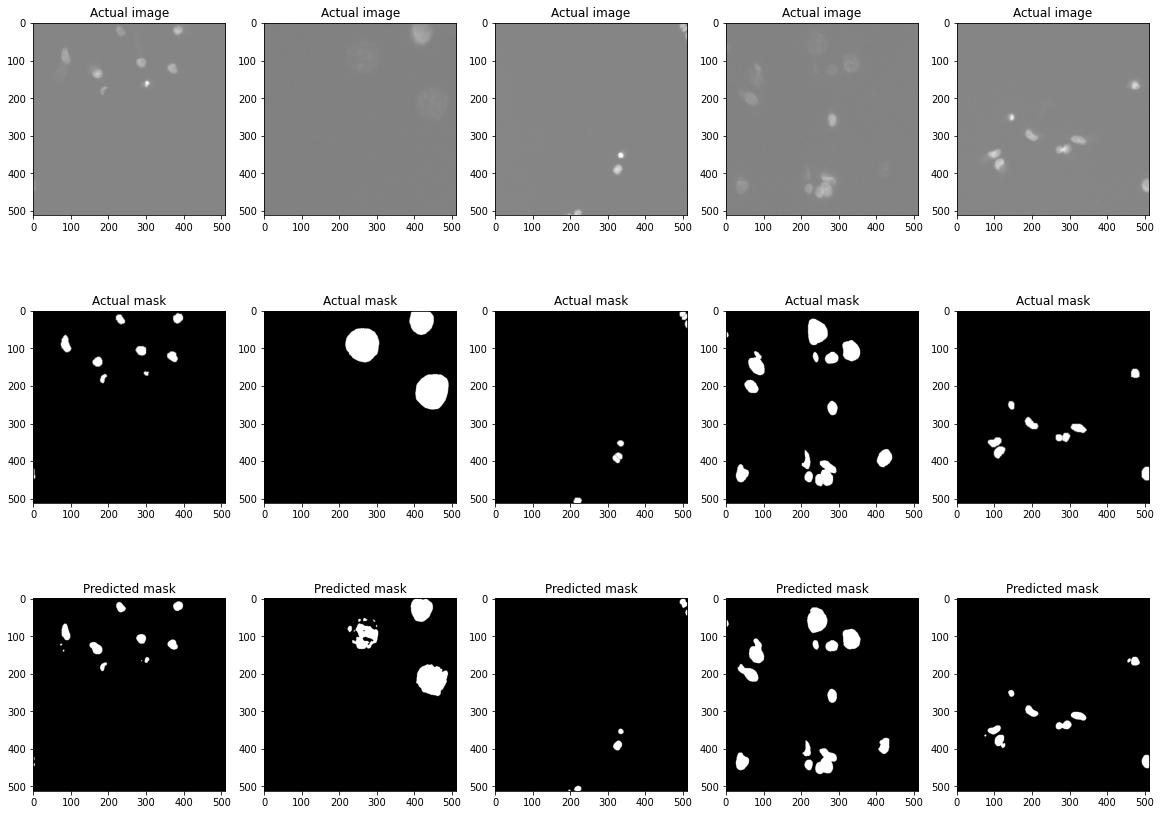

In [37]:
plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(sample[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(targets[i],cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(y_pred[i].squeeze(),cmap='gray')
plt.show()

As shown, the vanilla U-Net can predict the semantic segmentation quite well. 

## Exploration: Boundary finding
The vanilla U-Net is not instance-aware. To further predict segmentition, we are going to add boundary information.

In [22]:
class NucleusDataset2(torch.utils.data.Dataset):
    def __init__(self, root, train=True, min_dim=MIN_DIM, crop_dim=CROP_DIM, filter_ids=[], transforms=None, use_rle = False, rle_file=None):
        self.root=root # e.g. "stage1_train"
        self.train=train # will resize and random crop the image if True
        self.resize_t=T.Resize((min_dim,min_dim))
        self.crop_dim=crop_dim
        self.transforms = transforms
        self.use_rle = use_rle
        self.rle_file = rle_file 

        # a subset of the train set is being used as validation: "filter_ids": the image ids for validation 
        if(len(filter_ids)>0):
            if(train):
                img_ids=next(os.walk(root))[1]
                self.img_ids=list(set(img_ids) - set(filter_ids))
            else:
                self.img_ids=filter_ids
        else:
            self.img_ids=next(os.walk(root))[1]
        
    def __getitem__(self, idx):

        if(type(idx) == type("")):  # Note: don't use this when sending to model on cuda device
            image_id = idx
            idx=self.img_ids.index(image_id)
        else:
            image_id = self.img_ids[idx] # Use numerical index when sending to model on cuda device
          
        # Load image
        img_file = os.path.join(self.root, image_id, "images", image_id+".png")
        image = Image.open(img_file).convert("RGB") # must return PIL image 
        
        
        # Load masks 
        if (self.use_rle):
            rle_file = pd.read_csv(self.rle_file)
            # Use decoder to get mask from rle file
            rle_masks = rle_file.loc[rle_file['ImageId'] == image_id, 'EncodedPixels'].tolist()
            masks = np.empty((len(rle_masks),image.height,image.width), dtype=bool)
            for i, mask in enumerate(rle_masks):
                masks[i] = rle_decode(mask,(image.width,image.height))
            masks = torch.as_tensor(masks, dtype=torch.float32)
            masks, mask= find_boundary(masks, image.height, image.width)
        else:
            # Masks are a series of binary images - one per nucleus
            mask_files = next(os.walk(os.path.join(self.root, image_id, "masks")))[2]
            masks = np.empty((len(mask_files),image.height,image.width), dtype=bool)
            

            for i,mask_file in enumerate(mask_files):
                masks[i] = io.imread(os.path.join(self.root, image_id, "masks", mask_file)) != 0
            masks = torch.as_tensor(masks, dtype=torch.float32)
            masks, mask= find_boundary(masks, image.height, image.width)
        # resize image
            
        image=self.resize_t(image)

        # resize masks
        masks=self.resize_t(masks)
        mask=self.resize_t(mask)

        merged_mask = np.zeros((512, 512, 1), dtype=bool)
        for i in range(len(masks)):
            mask_ = masks[i]
            mask_ = np.expand_dims(mask_,axis=-1)
            merged_mask = np.maximum(merged_mask, mask_)
        
        label = {'mask':mask.to(dtype=torch.float32),'merged_mask':merged_mask}
        
        image = T.functional.to_tensor(image)

        if self.transforms is not None: 
            # these transforms must change both image and target as appropriate
            image, merged_mask = self.transforms(image, merged_mask)
        return image.to(dtype=torch.float32), label
    
    def __len__(self):
        return len(self.img_ids)

Define function to detech boundary\
There are 2 type of boundary: class-wise and instance-wise

In [23]:
# This for class-wise boundary
def find_boundary(masks, height=512, weight=512):
    mask = np.zeros((3,height,weight), dtype = float)
    for the_mask in masks:
        # Find the mask
        mask[1] = np.maximum(mask[1], the_mask)
        # Find boundray
    for h in range(1,height-1):
        for w in range(1,weight-1):
            classifier = (mask[1][h+1][w]+mask[1][h][w+1]+mask[1][h-1][w]+mask[1][h][w-1]).astype(float)
            if (classifier<=3)&(classifier>=1):
                mask[2][h][w] = 1
    mask[0] = (mask[1]==0)&(mask[2]==0)
    merged_mask = mask[1]
    mask[1] = mask[1]-((mask[1]==1)&(mask[2]==1))
    return masks, torch.as_tensor(mask, dtype=torch.float32)

In [24]:
num_epochs=10
bs = 6
dataset_dict2 = {
    'train': NucleusDataset2(TRAIN_PATH, train=True, filter_ids=VAL_IMAGE_IDS), 
    'validate': NucleusDataset2(TRAIN_PATH, train=False, filter_ids=VAL_IMAGE_IDS ) 
    }
data_loader_dict2 = {
    'train':torch.utils.data.DataLoader(dataset_dict2['train'],
                                        batch_size=bs, 
                                        shuffle=True
                                        ),
                    
    'validate':torch.utils.data.DataLoader(dataset_dict2['validate'],
                                        batch_size=bs, 
                                        shuffle=False)
    }

In [25]:
sample, targets = next(iter(data_loader_dict2['train']))

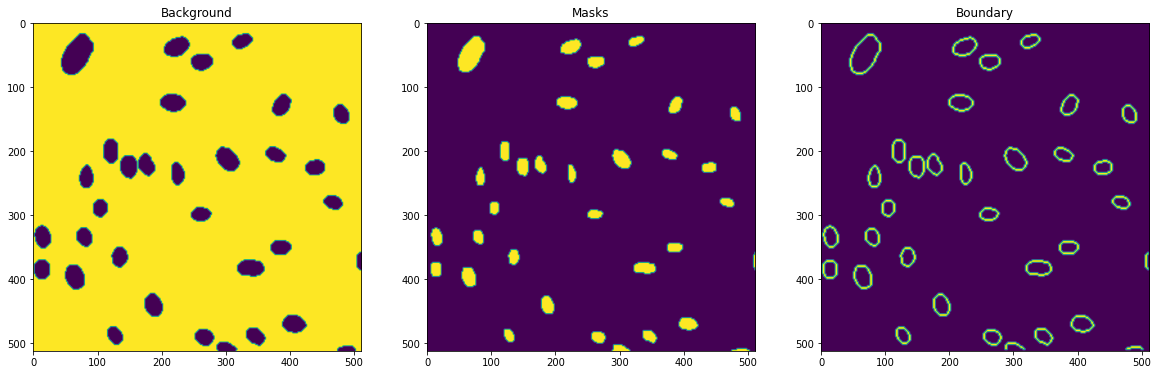

In [41]:
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.title('Background')
plt.imshow(targets['mask'][0][0])
plt.subplot(1,3,2)
plt.title('Masks')
plt.imshow(targets['mask'][0][1])
plt.subplot(1,3,3)
plt.title('Boundary')
plt.imshow(targets['mask'][0][2])

Use UNet model with 3 output channels.

Define train loop

In [42]:
def train_model2(model, dataloader, optimizer,loss_fn, scheduler, num_epochs = 10, use_checkpoint=True, file_pre="model_state"):

    score_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}

    best_score = 0
    best_model_epoch=0
    best_model_wts=None
    phases = ['train','validate']
    since = time.time()
        
    for i in range(num_epochs):
        
        if(use_checkpoint):
            (model, optimizer, scheduler, i,
            score_dict, loss_dict, best_model_epoch,
            best_model_wts, best_score) = load_checkpoint(model, 
                                                         optimizer, 
                                                         scheduler,
                                                         filename=f"{file_pre}_checkpoint.pt.tar")
                            
        if(i >= num_epochs):
            break  # in case we've already run all epochs
            
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        
        for p in phases:
            
            running_total = 0
            running_loss = 0
            running_score = 0
            
            if p == 'train':
                model.train()
            else:
                model.eval()
            
            # loop through batches:
            #for n, (images,targets) in tqdm(enumerate(dataloader[p]), total=len(dataloader[p])):
            for images,masks in dataloader[p]:
            
                num_imgs=len(images)
                mask = masks['labeled_mask']
                merged_mask = masks['merged_mask']
                images, merged_mask, mask = images.to(device), merged_mask.to(device), mask.to(device)


                if p == 'train':
                    outputs = model(images) # (N, 3 ,512, 512)
                    loss = loss_fn(outputs, mask) 
                    model.zero_grad()
                    loss.backward()
                    optimizer.step()
                    score = iou_batch2(outputs,merged_mask)
                    running_loss += loss.item()*num_imgs
                    running_score += score*num_imgs
                else:
                    with torch.no_grad():
                        outputs = model(images)
                        loss = loss_fn(outputs,mask)
                        score = iou_batch2(outputs,merged_mask)
                        running_score+=score*num_imgs
                        running_loss+=loss.item()*num_imgs
                        
                running_total += num_imgs

            
                    
            # Finish up for the epoch:
            if p == 'train':
                epoch_loss=float(running_loss/running_total)
                score_dict['train'].append(float(running_score / running_total))
                loss_dict['train'].append(epoch_loss)  
                elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - since))))
                print('Train set |  Average Loss: {:.4f} | Average Score: {:6.4f} | time elapse: {:>9}'.format(
                    loss_dict['train'][-1], score_dict['train'][-1], elapse))

                if scheduler is not None:
                    scheduler.step()

            else: #p == 'validate':
                epoch_loss=float(running_loss/running_total)
                epoch_score = float(running_score / running_total)
                score_dict['validate'].append(epoch_score)
                loss_dict['validate'].append(epoch_loss)  
                elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - since))))
                print('Validation set |  Average Loss: {:.4f} | Average Score: {:6.4f} | time elapse: {:>9}'.format(
                    loss_dict['validate'][-1], score_dict['validate'][-1], elapse))

                if epoch_score > best_score: 
                    best_score = epoch_score
                    best_model_wts = model.state_dict()
                    best_model_epoch=i
                    
            # SAVE STATE AT END OF EPOCH
        if(use_checkpoint):
                    state = {'epoch': i+1,
                         'state_dict': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'score_dict': score_dict,
                         'loss_dict': loss_dict,
                         'best_score': best_score,
                         'best_model_epoch': best_model_epoch,
                         'best_model_wts': best_model_wts,
                         } 
                    torch.save(state, f"{file_pre}_checkpoint.pt.tar")
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val score: {:6f}'.format(best_score))
    
    model.load_state_dict(best_model_wts)
    return model,score_dict, loss_dict

In [48]:
def eval_model2(model, dataloader):                            
    running_total = 0
    running_score = 0
    model.eval()
    for images,masks in (dataloader):
        mask = masks['mask']
        merged_mask = masks['merged_mask']
        num_imgs=len(images)
        images, merged_mask = images.to(device), merged_mask.to(device)
        with torch.no_grad():
            outputs = model(images)
            score = iou_batch2(outputs,merged_mask)
            running_score+=score*num_imgs

        running_total += num_imgs

    mean_score= float(running_score/running_total)
                
    print('Test IoU: {:.6f}'.format(mean_score))

In [43]:
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch2(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
    y_pred = y_pred.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou 

In [44]:
model2 = UNet(out_channels = 3)
model2.to(device)

params = [p for p in model2.parameters() if p.requires_grad]
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(params, lr=1e-4) 
lambda_func = lambda epoch: 0.5 ** epoch 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [47]:
model2, score2, loss2 = train_model2(model2, 
                        dataloader = data_loader_dict2, 
                        optimizer = optimizer, 
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        use_checkpoint=True, file_pre="Unet-working2"
                          )

=> loading checkpoint 'Unet-working2_checkpoint.pt.tar'
=> loaded checkpoint 'Unet-working2_checkpoint.pt.tar' (epoch 10)
Training complete in 0m 4s
Best val score: 0.605265


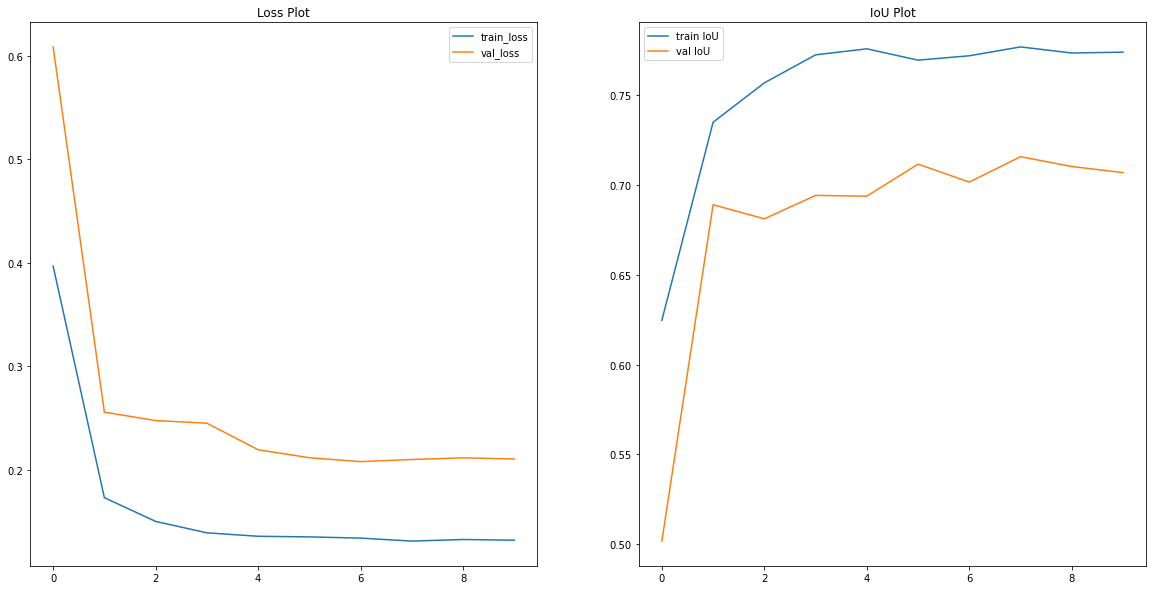

In [63]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(loss2['train'],label='train_loss')
plt.plot(loss2['validate'],label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(score2['train'],label='train IoU')
plt.plot(score2['validate'],label='val IoU')
plt.legend()
plt.title('IoU Plot')
plt.show()

In [49]:
bs =6
test_dataset2=NucleusDataset2(TEST_PATH, train=False, use_rle = True, rle_file = 'stage1_solution.csv')
test_loader2 = torch.utils.data.DataLoader(test_dataset2,
                                        batch_size=bs, 
                                        shuffle=False)

In [50]:
eval_model2(model2, test_loader2)

/tmp/ipykernel_5679/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5679/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5679/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5679/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5679/514579660.py:14: UserWarning

Test IoU: 0.800777


/tmp/ipykernel_5679/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


Now try instacne-wise boundary

In [17]:
class NucleusDataset2(torch.utils.data.Dataset):
    def __init__(self, root, train=True, min_dim=MIN_DIM, crop_dim=CROP_DIM, filter_ids=[], transforms=None, use_rle = False, rle_file=None):
        self.root=root # e.g. "stage1_train"
        self.train=train # will resize and random crop the image if True
        self.resize_t=T.Resize((min_dim,min_dim))
        self.crop_dim=crop_dim
        self.transforms = transforms
        self.use_rle = use_rle
        self.rle_file = rle_file 

        # a subset of the train set is being used as validation: "filter_ids": the image ids for validation 
        if(len(filter_ids)>0):
            if(train):
                img_ids=next(os.walk(root))[1]
                self.img_ids=list(set(img_ids) - set(filter_ids))
            else:
                self.img_ids=filter_ids
        else:
            self.img_ids=next(os.walk(root))[1]
        
    def __getitem__(self, idx):

        if(type(idx) == type("")):  # Note: don't use this when sending to model on cuda device
            image_id = idx
            idx=self.img_ids.index(image_id)
        else:
            image_id = self.img_ids[idx] # Use numerical index when sending to model on cuda device
          
        # Load image
        img_file = os.path.join(self.root, image_id, "images", image_id+".png")
        image = Image.open(img_file).convert("RGB") # must return PIL image

        # Load masks 
        if (self.use_rle):
            rle_file = pd.read_csv(self.rle_file)
            # Use decoder to get mask from rle file
            rle_masks = rle_file.loc[rle_file['ImageId'] == image_id, 'EncodedPixels'].tolist()
            masks = np.empty((len(rle_masks),image.height,image.width), dtype=bool)
            for i, mask in enumerate(rle_masks):
                masks[i] = rle_decode(mask,(image.width,image.height))
            masks, labeled_mask= find_boundary(masks, image.height, image.width)
        else:
            # Masks are a series of binary images - one per nucleus
            mask_files = next(os.walk(os.path.join(self.root, image_id, "masks")))[2]
            masks = np.empty((len(mask_files),image.height,image.width), dtype=bool)
            

            for i,mask_file in enumerate(mask_files):
                masks[i] = io.imread(os.path.join(self.root, image_id, "masks", mask_file)) != 0
            masks, labeled_mask= find_boundary(masks, image.height, image.width)
            #masks = torch.as_tensor(masks, dtype=torch.float32)
        # resize image
            
        image=self.resize_t(image)

        # resize masks
        masks=self.resize_t(masks)
        labeled_mask=self.resize_t(labeled_mask)
        
        # Merge masks
        merged_mask = np.zeros((512, 512, 1), dtype=bool)
        for i in range(len(masks)):
                mask_ = masks[i]
                mask_ = np.expand_dims(mask_,axis=-1)
                merged_mask = np.maximum(merged_mask, mask_)
        
        label = {'merged_mask':merged_mask, 'labeled_mask':labeled_mask}
        
        image = T.functional.to_tensor(image)

        if self.transforms is not None: 
            # these transforms must change both image and target as appropriate
            image, merged_mask = self.transforms(image, merged_mask)
        return image.to(dtype=torch.float32), label
    
    def __len__(self):
        return len(self.img_ids)

In [15]:
# This is for instance-wise boundary
def find_boundary(masks, height=512, weight=512):
    labeled_mask = np.zeros((3,height,weight), dtype = float)
    for i, the_mask in enumerate(masks):
        the_mask = the_mask.astype(float)
        labeled_mask[1]+=(the_mask)*i
    labeled_mask[2] = segmentation.find_boundaries(labeled_mask[1], mode='inner')
    labeled_mask[1]=(labeled_mask[1]>0)&(labeled_mask[2]==0)
    labeled_mask[0] = (labeled_mask[1]==0)&(labeled_mask[2]==0)
    return torch.as_tensor(masks, dtype=torch.float32), torch.as_tensor(labeled_mask, dtype=torch.float32)

In [ ]:
sample, targets = next(iter(data_loader_dict2['train']))

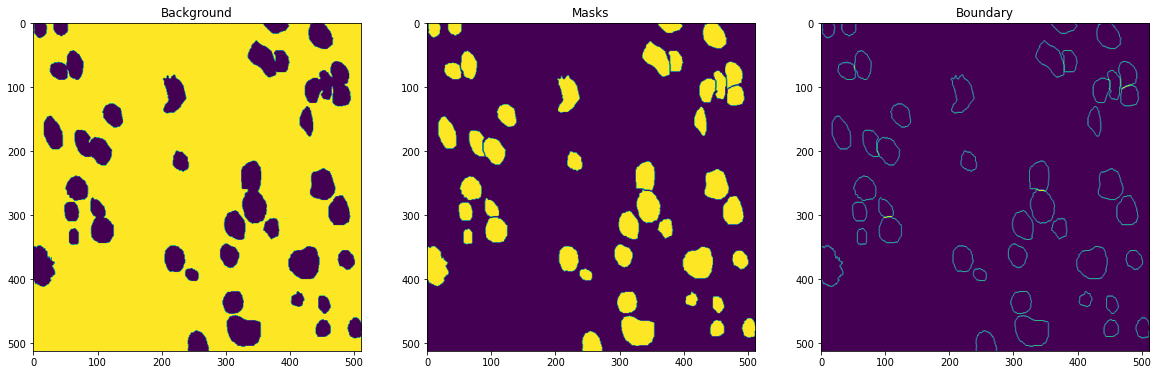

In [85]:
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.title('Background')
plt.imshow(target['labeled_mask'][1][0])
plt.subplot(1,3,2)
plt.title('Masks')
plt.imshow(target['labeled_mask'][1][1])
plt.subplot(1,3,3)
plt.title('Boundary')
plt.imshow(target['labeled_mask'][1][2])

In [89]:
model2, score2, loss2 = train_model2(model2, 
                        dataloader = data_loader_dict2, 
                        optimizer = optimizer, 
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        use_checkpoint=True, file_pre="U-Net_instacnes"
                          )

=> no checkpoint found at 'U-Net_instacnes_checkpoint.pt.tar'
Epoch: 0/9
----------


/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


Train set |  Average Loss: 0.4321 | Average Score: 0.6472 | time elapse:  00:04:34
Validation set |  Average Loss: 0.2766 | Average Score: 0.5714 | time elapse:  00:04:48
=> loading checkpoint 'U-Net_instacnes_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_instacnes_checkpoint.pt.tar' (epoch 1)
Epoch: 1/9
----------
Train set |  Average Loss: 0.1799 | Average Score: 0.7430 | time elapse:  00:08:03
Validation set |  Average Loss: 0.2446 | Average Score: 0.6190 | time elapse:  00:08:12
=> loading checkpoint 'U-Net_instacnes_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_instacnes_checkpoint.pt.tar' (epoch 2)
Epoch: 2/9
----------
Train set |  Average Loss: 0.1519 | Average Score: 0.7688 | time elapse:  00:11:30
Validation set |  Average Loss: 0.2308 | Average Score: 0.6747 | time elapse:  00:11:39
=> loading checkpoint 'U-Net_instacnes_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_instacnes_checkpoint.pt.tar' (epoch 3)
Epoch: 3/9
----------
Train set |  Average Loss: 0.1441 | Average Sc

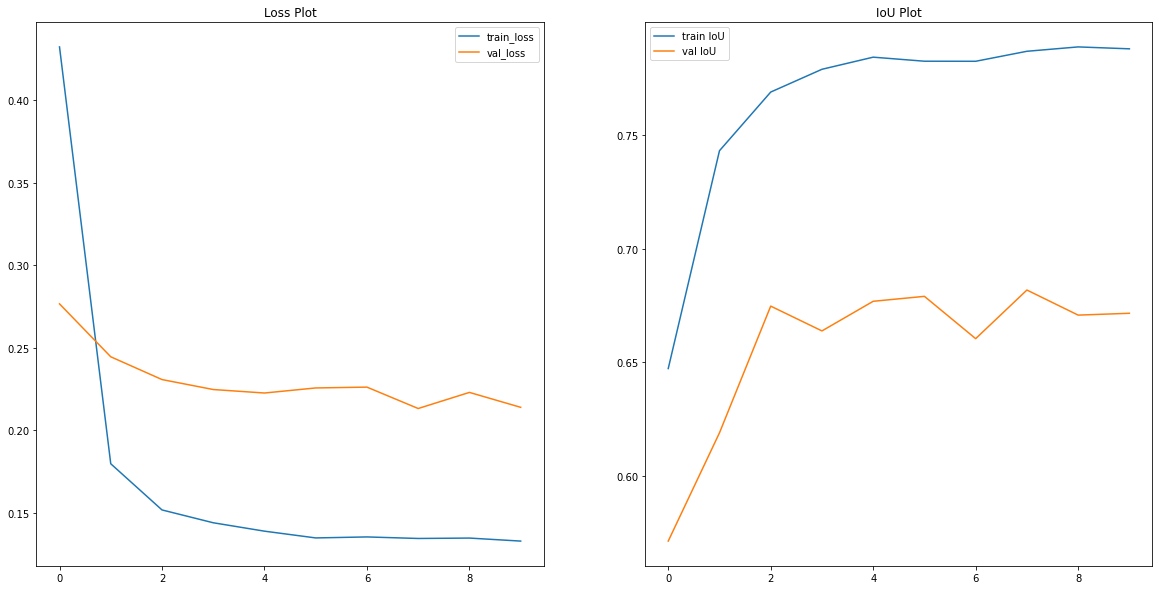

In [90]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(loss2['train'],label='train_loss')
plt.plot(loss2['validate'],label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(score2['train'],label='train IoU')
plt.plot(score2['validate'],label='val IoU')
plt.legend()
plt.title('IoU Plot')
plt.show()

In [24]:
def eval_model2(model, dataloader):                            
    running_total = 0
    running_score = 0
    model.eval()
    for images,masks in (dataloader):
        mask = masks['labeled_mask']
        merged_mask = masks['merged_mask']
        num_imgs=len(images)
        images, merged_mask = images.to(device), merged_mask.to(device)
        with torch.no_grad():
            outputs = model(images)
            score = iou_batch2(outputs,merged_mask)
            running_score+=score*num_imgs

        running_total += num_imgs

    mean_score= float(running_score/running_total)
                
    print('Test IoU: {:.6f}'.format(mean_score))

In [25]:
bs =6
test_dataset2=NucleusDataset2(TEST_PATH, train=False, use_rle = True, rle_file = 'stage1_solution.csv')
test_loader2 = torch.utils.data.DataLoader(test_dataset2,
                                        batch_size=bs, 
                                        shuffle=False)

In [95]:
eval_model2(model2, test_loader2)

/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_6197/514579660.py:14: UserWarning

Test IoU: 0.640369


/tmp/ipykernel_6197/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


In [27]:
sample, targets = next(iter(test_loader2))

In [107]:
sample = sample.to(device)
y_pred = model2(sample)
y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
y_pred = y_pred.cpu().detach().numpy()

/tmp/ipykernel_6197/3597827615.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


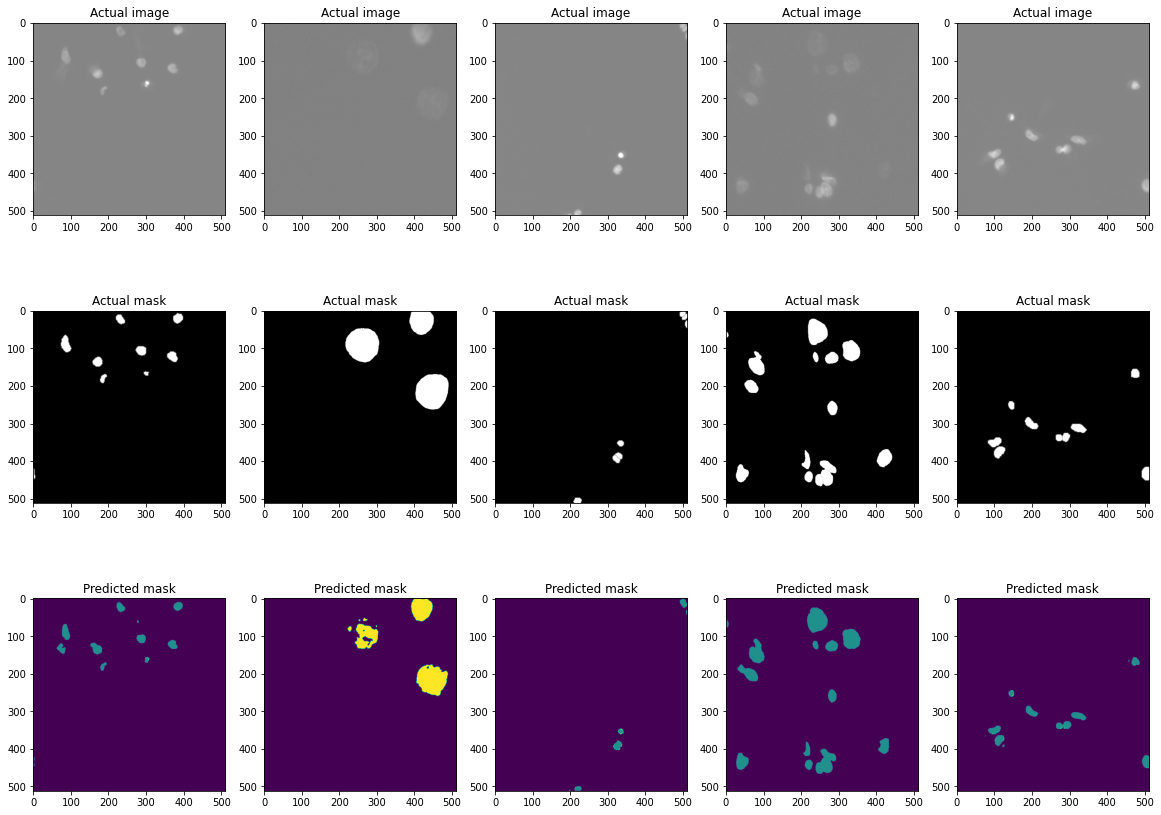

In [116]:
plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(sample[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(targets['merged_mask'][i],cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(y_pred[i])
plt.show()

In [152]:
# To get separate masks:
from skimage import measure

#an image with background==0, border==2 and interior==1
regions=(y_pred[3]==1).astype('uint8')

labeled_regions=measure.label(regions)
#plt.imshow(labeled_regions, cmap='jet')

obj_ids = np.unique(labeled_regions)
obj_ids = obj_ids[1:]
masks = labeled_regions == obj_ids[:, None, None]


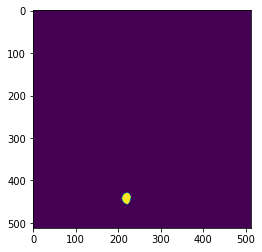

In [169]:
plt.imshow(masks[12])

###  Use weighted cross entropy loss
As the boundray and interior have varied size, weighte corss entropy loss was employed.\
First, check the weight of background, interior and boundaray.

In [175]:
import warnings

if(True):
    ave_class_weights=np.array([0.,0.,0.])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        img_ids=next(os.walk(TRAIN_PATH))[1]

        for i,image_id in enumerate(img_ids):

            if(i % 100 == 0):
                print(i)


            # Load image
            img_file = os.path.join(TRAIN_PATH, image_id, "images", image_id+".png")
            image = Image.open(img_file).convert("RGB") # must return PIL image 

            # Load masks - masks are a series of binary images - one per nucleus
            mask_files = next(os.walk(os.path.join(TRAIN_PATH, image_id, "masks")))[2]

            labeled_masks=np.zeros((image.height,image.width), dtype='uint32')
            for i,mask_file in enumerate(mask_files):
                cur_mask = io.imread(os.path.join(TRAIN_PATH, image_id, "masks", mask_file)).astype('uint32')
                cur_mask=(cur_mask//255)*i
                labeled_masks+=cur_mask

            boundary_img=segmentation.find_boundaries(labeled_masks, mode='inner')

            # 0/1 background/nuclei
            labeled_masks=(labeled_masks>0).astype('uint8')
            
            # 0/1/2 background/nuclei/boundary
            labeled_masks = labeled_masks + (boundary_img.astype('uint8')*1) 
            
            # class weights for weighted loss
            class_weights=(image.height*image.width) / (3 * np.bincount(labeled_masks.flatten()))
            
            ave_class_weights+=class_weights

            #save_file=os.path.join(TRAIN_PATH, image_id, image_id+'_boundaries.png')
            #io.imsave(save_file, labeled_masks)
            
        ave_class_weights=ave_class_weights/len(img_ids)
        
print(ave_class_weights)


0
100
200
300
400
500
600
[ 0.39173999 10.32560528 38.03282406]


Then change the weight to torch tensor and saved for training.

In [21]:
weight = np.array([0.39173999,10.32560528,38.03282406])
weight = torch.as_tensor(weight, dtype=torch.float32)

Now retrain with weighted loss function

In [22]:
model_weighted = UNet(out_channels = 3)
model_weighted.to(device)

weight = weight.to(device)
params = [p for p in model_weighted.parameters() if p.requires_grad]
loss_fn = nn.CrossEntropyLoss(weight = weight)
optimizer = Adam(params, lr=1e-4) 
lambda_func = lambda epoch: 0.5 ** epoch 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

In [23]:
model_weighted, score_weighted, loss_weighted = train_model2(model_weighted, 
                        dataloader = data_loader_dict2, 
                        optimizer = optimizer, 
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        use_checkpoint=True, file_pre="U-Net_weighted"
                          )

=> loading checkpoint 'U-Net_weighted_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_weighted_checkpoint.pt.tar' (epoch 4)
Epoch: 4/9
----------


/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


Train set |  Average Loss: 0.9516 | Average Score: 0.5090 | time elapse:  00:04:37
Validation set |  Average Loss: 1.4983 | Average Score: 0.5113 | time elapse:  00:04:50
=> loading checkpoint 'U-Net_weighted_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_weighted_checkpoint.pt.tar' (epoch 5)
Epoch: 5/9
----------
Train set |  Average Loss: 0.9416 | Average Score: 0.5101 | time elapse:  00:08:10
Validation set |  Average Loss: 1.4375 | Average Score: 0.5159 | time elapse:  00:08:18
=> loading checkpoint 'U-Net_weighted_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_weighted_checkpoint.pt.tar' (epoch 6)
Epoch: 6/9
----------
Train set |  Average Loss: 0.9416 | Average Score: 0.5178 | time elapse:  00:11:38
Validation set |  Average Loss: 1.3862 | Average Score: 0.5306 | time elapse:  00:11:46
=> loading checkpoint 'U-Net_weighted_checkpoint.pt.tar'
=> loaded checkpoint 'U-Net_weighted_checkpoint.pt.tar' (epoch 7)
Epoch: 7/9
----------
Train set |  Average Loss: 0.9436 | Average Score: 0

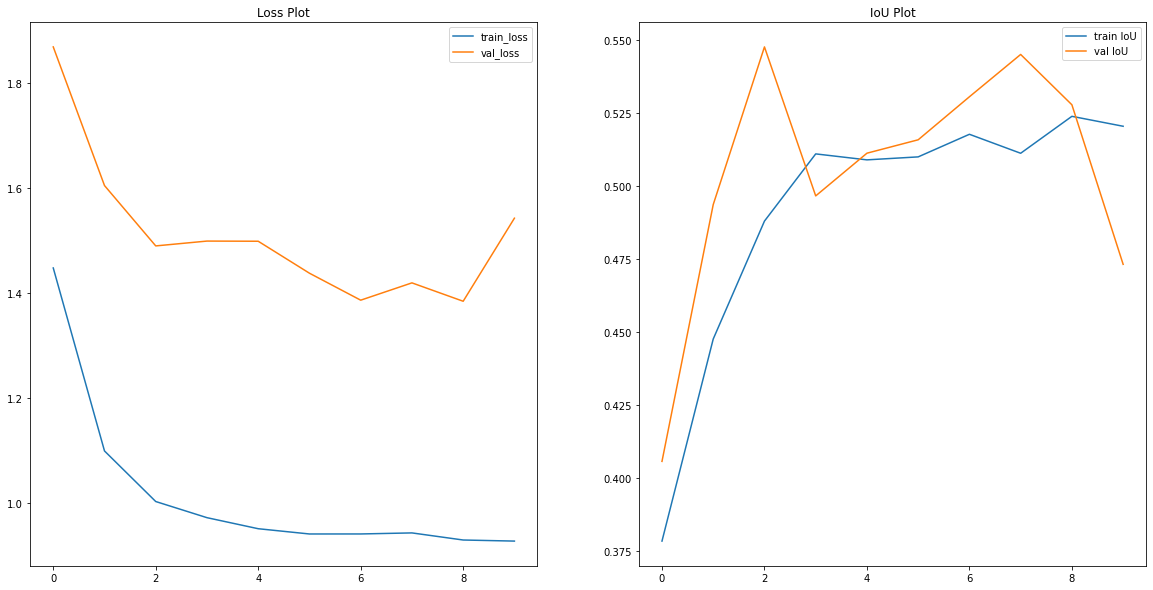

In [35]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(loss_weighted['train'],label='train_loss')
plt.plot(loss_weighted['validate'],label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(score_weighted['train'],label='train IoU')
plt.plot(score_weighted['validate'],label='val IoU')
plt.legend()
plt.title('IoU Plot')
plt.show()

In [26]:
eval_model2(model_weighted, test_loader2)

/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
/tmp/ipykernel_5498/514579660.py:14: UserWarning

Test IoU: 0.628708


/tmp/ipykernel_5498/514579660.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


In [28]:
sample = sample.to(device)
y_pred = model_weighted(sample)
y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)
y_pred = y_pred.cpu().detach().numpy()

/tmp/ipykernel_5498/3362123661.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(y_pred).data.max(1).indices # (N,3,512,512) to (N,512,512)


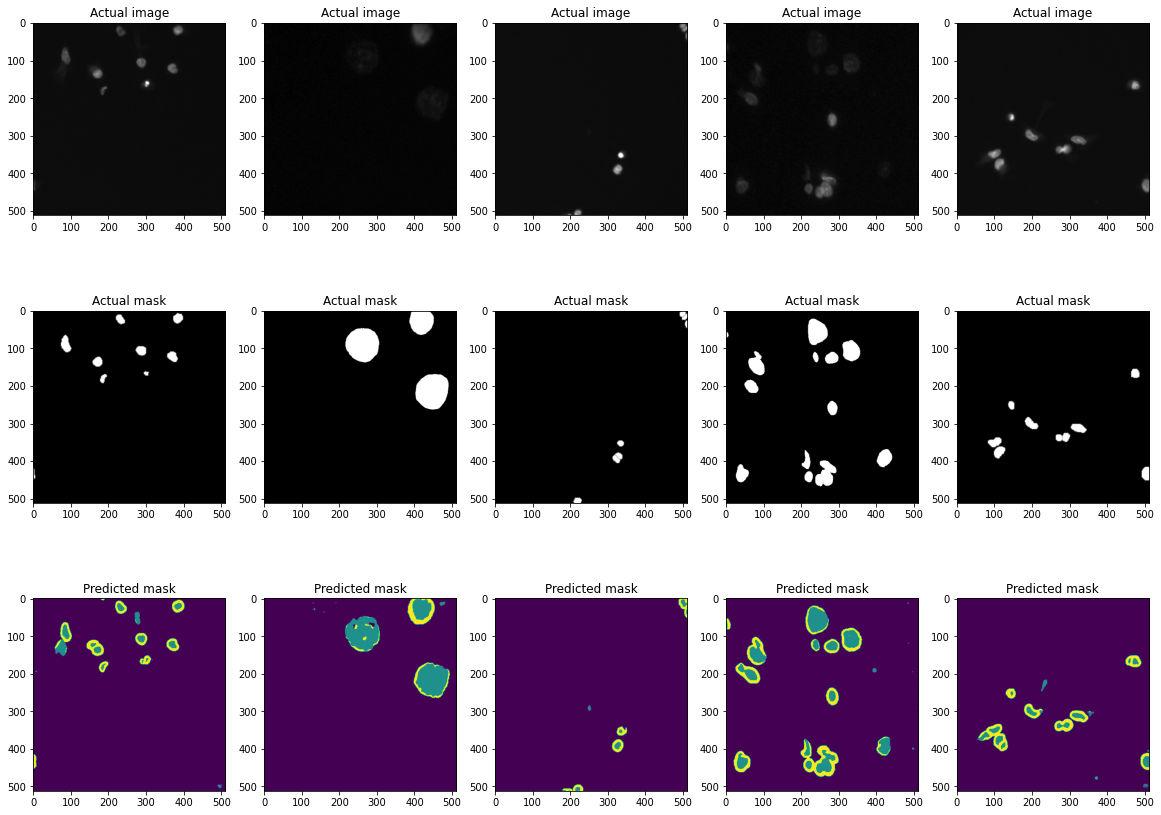

In [33]:
plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(np.transpose(sample[i].cpu().detach().numpy(), (1, 2, 0)))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(targets['merged_mask'][i],cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(y_pred[i])
plt.show()